<a href="https://colab.research.google.com/github/PulkitAppz/Capstone_AIML_19B/blob/master/DenseNet_Capstone_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing pydicom to read dcm files
!pip install -q pydicom

     |████████████████████████████████| 35.5MB 97kB/s 


In [2]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
%matplotlib inline

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Set path to G-Drive
from google.colab import drive
drive.mount('/content/drive')
print(os. getcwd())
print(os.listdir())
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone')

Mounted at /content/drive
/content
['.config', 'drive', 'sample_data']


# Reading data from updated Dataframe

In [4]:
data_df = pd.read_csv(('updated_dataframe.csv'))

In [6]:
display(data_df.shape, data_df.head())

(30227, 12)

,Unnamed: 0,Unnamed: 0.1,patientId,x,y,width,height,Target,class,PathName,Age,Gender
0,0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,51,F
1,1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,48,F
2,2,2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,19,M
3,3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,28,M
4,4,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,32,F


In [7]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = data_df[['patientId', 'PathName', 'class', 'Target']].copy(deep = True)
path_class_target['PathName'] = (path_class_target['PathName']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))

path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
PathName     26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [8]:
path_class_target.head()

,patientId,PathName,class,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,stage_2_train_images_png/0004cfab-14fd-4e49-80...,No Lung Opacity / Not Normal,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,stage_2_train_images_png/00313ee0-9eaa-42f4-b0...,No Lung Opacity / Not Normal,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,stage_2_train_images_png/00322d4d-1c29-4943-af...,No Lung Opacity / Not Normal,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,stage_2_train_images_png/003d8fa0-6bf1-40ed-b5...,Normal,0
4,00436515-870c-4b36-a041-de91049b9ab4,stage_2_train_images_png/00436515-870c-4b36-a0...,Lung Opacity,1


In [8]:
# run to convert dcm to png or jpg.
'''import pydicom as dicom
import os
import cv2
import PIL # optional
# make it True if you want in PNG format
PNG = True
# Specify the .dcm folder path
folder_path = "stage_2_train_images"
# Specify the output jpg/png folder path
jpg_folder_path = "stage_2_train_images_png"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 1000 == 0:
        print('{} image converted'.format(n))'''

'import pydicom as dicom\nimport os\nimport cv2\nimport PIL # optional\n# make it True if you want in PNG format\nPNG = True\n# Specify the .dcm folder path\nfolder_path = "stage_2_train_images"\n# Specify the output jpg/png folder path\njpg_folder_path = "stage_2_train_images_png"\nimages_path = os.listdir(folder_path)\nfor n, image in enumerate(images_path):\n    ds = dicom.dcmread(os.path.join(folder_path, image))\n    pixel_array_numpy = ds.pixel_array\n    if PNG == False:\n        image = image.replace(\'.dcm\', \'.jpg\')\n    else:\n        image = image.replace(\'.dcm\', \'.png\')\n    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)\n    if n % 1000 == 0:\n        print(\'{} image converted\'.format(n))'

# Splitting data into Train, test and validate sets

In [9]:
image_list = list(path_class_target['PathName'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

In [10]:
df_train = (path_class_target.merge(pd.Series(X_train, name = 'PathName'), 
                                    on = 'PathName', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'PathName'), 
                                    on = 'PathName', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'PathName'), 
                                    on = 'PathName', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


In [11]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.77
1    0.23
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

# Dense Net 121

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from skimage.transform import resize
import math

In [13]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 5
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
Dense_MODEL = 'densenet.h5'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [15]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [16]:
df_train['PathName'][0]

'stage_2_train_images_png/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png'

In [17]:


# Data generator
#reference : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
class DataGenerators:
    def __init__(self, df_train, df_valid, df_test, batch_size, path,
                 img_size = (224, 224), class_mode = 'binary',
                 random_state = 2020):
        self.df_train = df_train
        self.df_valid = df_valid
        self.df_test = df_test
        self.batch_size = batch_size
        self.img_size = img_size
        self.path = path
        self.class_mode = class_mode
        
        train_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rotation_range = 20, width_shift_range = 0.2,
            height_shift_range = 0.2, zoom_range = 0.2,
            horizontal_flip = True, rescale = 1/255.
            )
        

      
        
        valid_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input, 
            rescale = 1/255.
            )
        
        test_augmenter = ImageDataGenerator(
            preprocessing_function = preprocess_input,
            rescale = 1/255.
            )
        
        print('Train Generator Created', '**'*20)
        print(self.path)
        self.train_generator = train_augmenter.flow_from_dataframe(
  
            x_col = 'PathName',
            y_col = 'Target',
            dataframe = self.df_train,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = None,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = True
            )
        print('Validation Generator Created', '**'*20)
        self.valid_generator = valid_augmenter.flow_from_dataframe(
            x_col = 'PathName',
            y_col = 'Target',
            dataframe = self.df_valid,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = None,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        print('Test Generator Created', '**'*20)
        self.test_generator = test_augmenter.flow_from_dataframe(
            x_col = 'PathName',
            y_col = 'Target',
            dataframe = self.df_test,
            batch_size = self.batch_size,
            target_size = self.img_size,
            directory = None,
            class_mode = self.class_mode,
            seed = random_state,
            shuffle = False
            )
        
        self.step_size_train = math.ceil(
            self.train_generator.n//self.train_generator.batch_size + 1
            )
        self.step_size_valid = math.ceil(
            self.valid_generator.n//self.valid_generator.batch_size + 1
            )
        self.step_size_test = math.ceil(
            self.test_generator.n//self.test_generator.batch_size + 1
            )

In [18]:
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = 'stage_2_train_images_png/', 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = 2020)

Train Generator Created ****************************************
stage_2_train_images_png/
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ****************************************
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ****************************************
Found 2668 validated image filenames belonging to 2 classes.


In [19]:
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint("model-{loss:.2f}.h5", monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = 'min')
    
    
    
    callbacks = [cp, lrscheduler]
    return callbacks


In [25]:
model = build_model()
callbacks = callbacks()
train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator  

Create a `DenseNet121` model
--------------------------------------------------------------------------------
Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseNet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [20]:
  
history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
print('Save the final weights'); print('--'*40)
model.save(Dense_MODEL)

Create a `DenseNet121` model
--------------------------------------------------------------------------------
29089792/29084464 [==============================] - 1s 0us/step
Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseNet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports

In [20]:
model = build_model()

Create a `DenseNet121` model
--------------------------------------------------------------------------------
29089792/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseNet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [39]:
model.load_weights(Dense_MODEL)

# Model Evaluation

In [40]:
loss, accuracy = model.evaluate_generator(generator = generators.valid_generator, 
                                          steps = generators.step_size_valid)


In [41]:
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Loss: 0.324, Accuracy: 0.861


In [42]:
print('Predict on the test data')
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)

Predict on the test data
84/84 [==============================] - 33s 394ms/step


In [43]:
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

84/84 [==============================] - 33s 394ms/step


In [44]:
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.88      0.95      0.91      2054
   Pneumonia       0.76      0.56      0.64       614

    accuracy                           0.86      2668
   macro avg       0.82      0.75      0.78      2668
weighted avg       0.85      0.86      0.85      2668



Confusion Matrix on the test data
--------------------------------------------------------------------------------


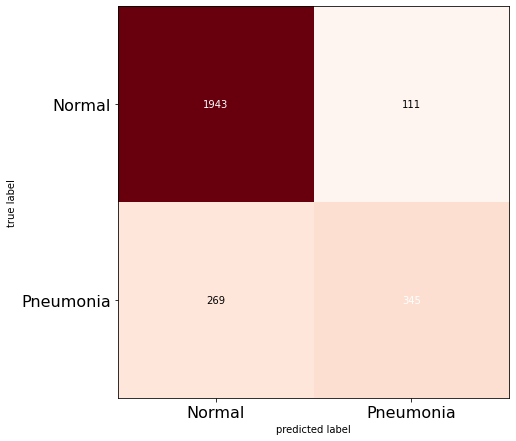

In [45]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Reds)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

# Link to weights : https://drive.google.com/file/d/1-2zo2SLekbPKbGa6IIQzJ1hBn-gG1cRw/view?usp=sharing

# PNG : https://drive.google.com/drive/folders/1AT_EazfOE67zpA0J8pqjgpZsu71NzDso?usp=sharing

# dataframe : https://drive.google.com/file/d/1U1WKB7p05vq8q0lIizKWq5zPzJA9u7sx/view?usp=sharing